<a href="https://colab.research.google.com/github/anapvalle/IAMA_aulas/blob/main/aula3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aula 2

In [ ]:
# execute this for the 1st time
#!pip install -r example-requirements.txt

# download file
!wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # colab

# and place in folder data/

--2024-06-21 22:33:40--  http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat
Resolving helon.usuarios.rdc.puc-rio.br (helon.usuarios.rdc.puc-rio.br)... 139.82.34.12
Connecting to helon.usuarios.rdc.puc-rio.br (helon.usuarios.rdc.puc-rio.br)|139.82.34.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267634147 (255M)
Saving to: ‘data3SS2009.mat’

data3SS2009.mat     100%[===================>] 255.24M  12.1MB/s    in 26s     

2024-06-21 22:34:06 (9.96 MB/s) - ‘data3SS2009.mat’ saved [267634147/267634147]



In [ ]:
import scipy.io as sio
import numpy as np
import os
from os import getcwd
from os.path import join
import matplotlib.pyplot as plt

In [ ]:
fname = join(getcwd(),'data3SS2009.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

#y
y_target = y>9 #maior que nove apresenta dano
y_target

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

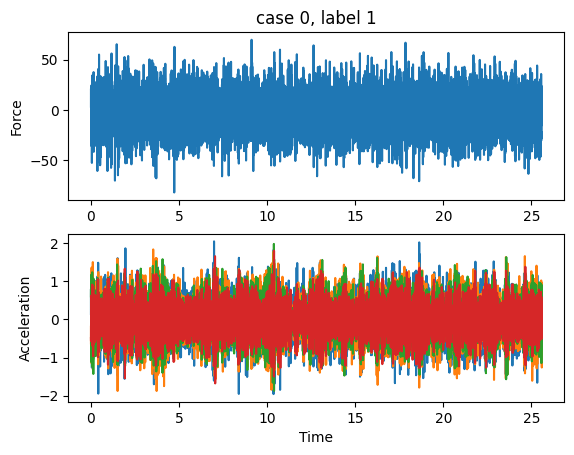

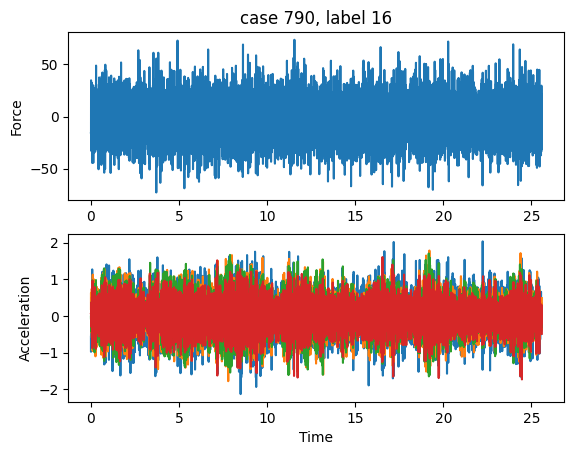

In [ ]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [ ]:
Ch2.shape

(8192, 850)

##Obtendo X1

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
na=30

FeatARCh2 = []
FeatARCh3 = []
FeatARCh4 = []
FeatARCh5 = []

for i in range(Nc):
  res1 = AutoReg(Ch2[:,i], lags = na, trend = 'n').fit()
  res2 = AutoReg(Ch3[:,i], lags = na, trend = 'n').fit()
  res3 = AutoReg(Ch4[:,i], lags = na, trend = 'n').fit()
  res4 = AutoReg(Ch5[:,i], lags = na, trend = 'n').fit()

  FeatARCh2.append(res1.params)
  FeatARCh3.append(res2.params)
  FeatARCh4.append(res3.params)
  FeatARCh5.append(res4.params)

FeatARCh2 = np.array(FeatARCh2)
FeatARCh3 = np.array(FeatARCh3)
FeatARCh4 = np.array(FeatARCh4)
FeatARCh5 = np.array(FeatARCh5)

X1 = np.concatenate([FeatARCh2, FeatARCh3,FeatARCh4,FeatARCh5], axis = 1)

X1.shape #850x120

(850, 120)

##Obtendo X2 com PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
X2 = pca.fit_transform(X1)

X2.shape

(850, 9)

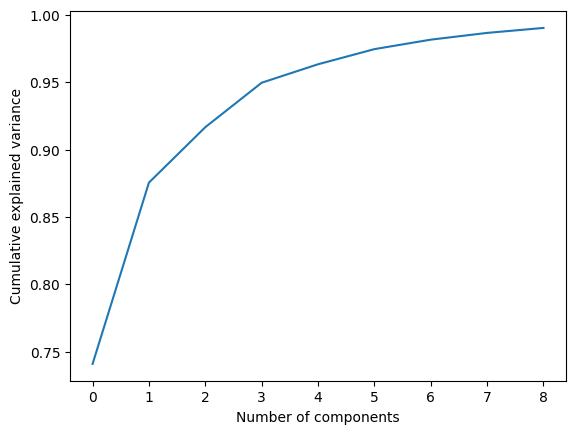

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

O gráfico acima demonstra que, ao aplicar o PCA, 8 componentes já são suficientes para "resumir" o problema que antes possuia 120.

##Dimensionando as features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
X2_scaled = scaler.fit_transform(X2)

In [ ]:
X2_scaled[0,:]

array([ 0.71809541, -0.76363142,  0.48308293,  0.17035063,  0.12463101,
       -0.4889556 , -0.10871274, -0.09689543, -0.04953569])

##Plotagem em espaços multidimensionais

In [ ]:
import pandas as pd

df = pd.concat([pd.DataFrame(X2_scaled), pd.DataFrame({'target':y_target})], axis=1)
df.describe()

,0,1,2,3,4,5,6,7,8
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,-0.290527,-0.318273,-0.044201,-0.187465,-0.003079,-0.053553,-0.002058,-0.169717,-0.020813
std,0.594815,0.513715,0.458378,0.473231,0.340975,0.365678,0.363123,0.365358,0.314010
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.863772,-0.744789,-0.373105,-0.583204,-0.237247,-0.259769,-0.198554,-0.475283,-0.246924
50%,-0.454583,-0.485672,-0.078901,-0.250273,-0.038903,-0.052325,-0.022831,-0.194082,-0.017230
75%,0.326800,-0.147692,0.230061,0.066362,0.198331,0.104222,0.211704,0.078847,0.194596
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


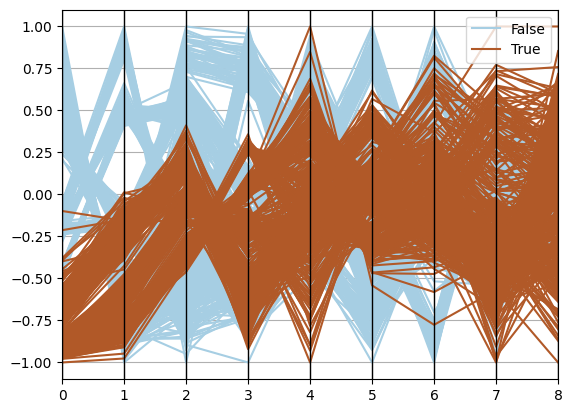

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

plt.figure()
pd.plotting.parallel_coordinates(df, 'target',colormap=plt.get_cmap("Paired"))
plt.show()

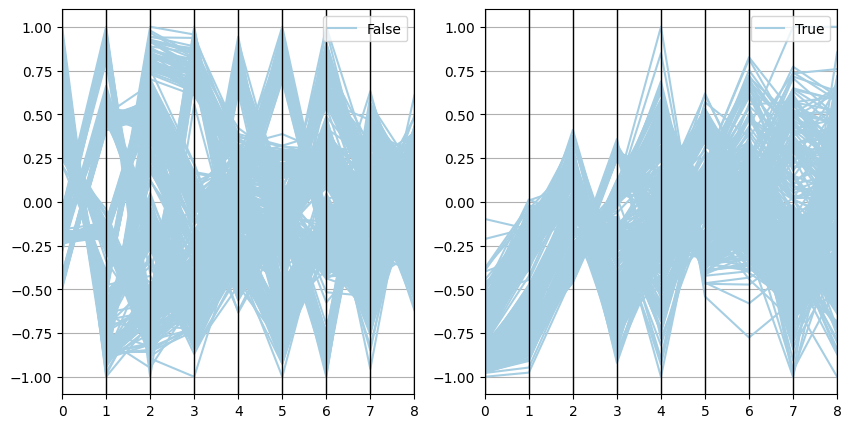

In [ ]:
plt.figure(figsize=[10,5])
plt.subplot(121)
pd.plotting.parallel_coordinates(df[df['target'] == 0],'target', colormap=plt.get_cmap("Paired"))
plt.subplot(122)
pd.plotting.parallel_coordinates(df[df['target'] == 1],'target', colormap=plt.get_cmap("Paired"))
plt.show()

###Comparando X1 e X2

In [ ]:
df_x1 = pd.concat([pd.DataFrame(X1), pd.DataFrame({'target':y_target})], axis=1)
df_x1.describe()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,...,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,-0.448378,-1.319961,-1.085619,-1.691286,-1.415480,-1.983106,-1.722363,-2.115620,-1.730317,-1.815951,...,0.500034,0.363227,0.425633,0.291826,0.346166,0.194185,0.201610,0.175332,0.004238,0.128766
std,0.055398,0.061882,0.080594,0.081969,0.101988,0.103996,0.117701,0.121582,0.123858,0.107503,...,0.090816,0.204835,0.091663,0.169893,0.062726,0.117792,0.061382,0.048639,0.046872,0.024761
min,-0.539366,-1.439600,-1.259052,-1.897233,-1.636261,-2.214443,-1.982029,-2.385271,-2.020690,-2.057738,...,0.221880,-0.037593,0.173133,-0.047043,0.064565,-0.048046,-0.013653,0.007222,-0.119680,0.059066
25%,-0.486661,-1.365126,-1.142706,-1.744658,-1.486013,-2.059545,-1.819305,-2.213119,-1.819819,-1.903813,...,0.441823,0.190896,0.364314,0.152423,0.301378,0.096484,0.158354,0.145497,-0.028311,0.111860
50%,-0.460480,-1.334200,-1.095366,-1.698576,-1.433079,-2.005749,-1.743741,-2.127841,-1.734871,-1.803369,...,0.488744,0.297884,0.410393,0.241916,0.347953,0.165522,0.200650,0.183038,0.001349,0.127729
75%,-0.424699,-1.281661,-1.021279,-1.632002,-1.345398,-1.906070,-1.610693,-2.002507,-1.619453,-1.734009,...,0.542587,0.576279,0.486115,0.452010,0.388506,0.307258,0.252582,0.213268,0.038168,0.146894
max,-0.241306,-1.126112,-0.854395,-1.467641,-1.117780,-1.667841,-1.461970,-1.844429,-1.491559,-1.587925,...,0.822145,0.795340,0.651496,0.650097,0.496437,0.430147,0.325199,0.297623,0.107219,0.195183


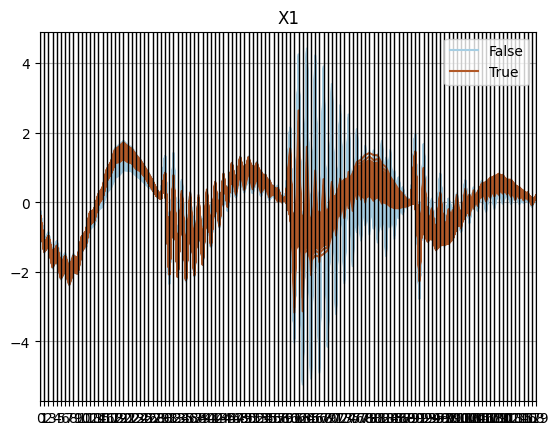

In [ ]:
plt.figure()
pd.plotting.parallel_coordinates(df_x1, 'target',colormap=plt.get_cmap("Paired"))
plt.title("X1")
plt.show()

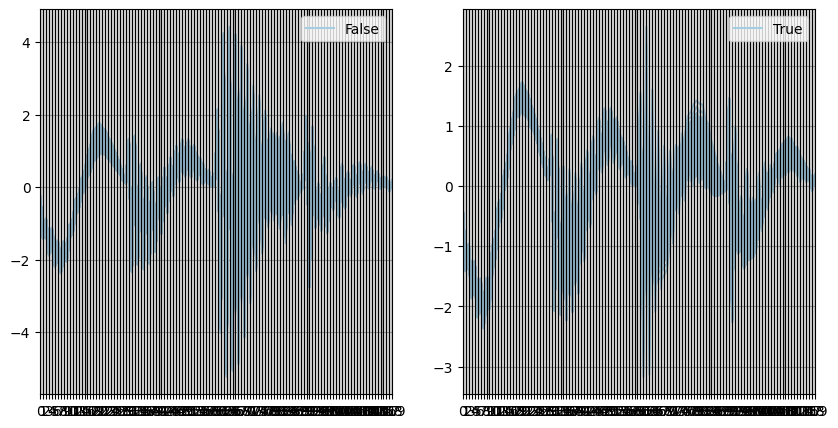

In [ ]:
plt.figure(figsize=[10,5])
plt.subplot(121)
pd.plotting.parallel_coordinates(df_x1[df_x1['target'] == 0],'target', colormap=plt.get_cmap("Paired"))
plt.subplot(122)
pd.plotting.parallel_coordinates(df_x1[df_x1['target'] == 1],'target', colormap=plt.get_cmap("Paired"))
plt.show()

In [ ]:
df_x2 = pd.concat([pd.DataFrame(X2), pd.DataFrame({'target':y_target})], axis=1)
df_x2.describe()

,0,1,2,3,4,5,6,7,8
count,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02
mean,1.069994e-15,4.012477e-16,-2.925764e-16,-5.517155e-16,5.015596e-17,4.346850e-16,5.851528e-16,-6.478478e-16,2.252838e-15
std,4.554778e+00,1.942015e+00,1.073628e+00,9.616691e-01,6.197143e-01,5.610932e-01,4.440808e-01,3.746351e-01,3.218798e-01
min,-5.432773e+00,-2.577157e+00,-2.238707e+00,-1.651181e+00,-1.811884e+00,-1.452219e+00,-1.220432e+00,-8.513648e-01,-1.003726e+00
25%,-4.389611e+00,-1.612376e+00,-7.703710e-01,-8.041951e-01,-4.255956e-01,-3.164147e-01,-2.403040e-01,-3.133242e-01,-2.317767e-01
50%,-1.256254e+00,-6.328244e-01,-8.127530e-02,-1.276345e-01,-6.510894e-02,1.884669e-03,-2.540388e-02,-2.498400e-02,3.672902e-03
75%,4.727157e+00,6.448523e-01,6.423852e-01,5.158105e-01,3.660594e-01,2.420892e-01,2.614207e-01,2.548752e-01,2.208076e-01
max,9.882170e+00,4.983509e+00,2.445764e+00,2.413090e+00,1.823076e+00,1.616562e+00,1.225466e+00,1.199417e+00,1.046396e+00


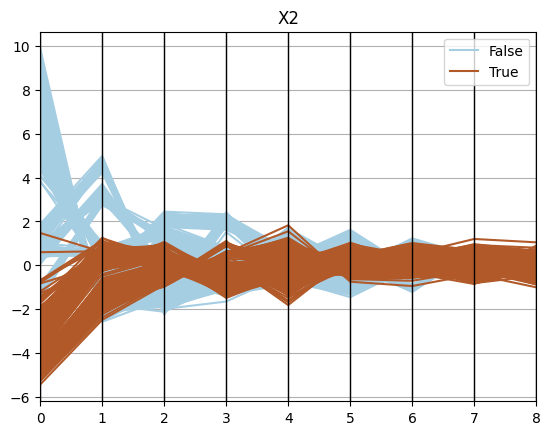

In [ ]:
plt.figure()
pd.plotting.parallel_coordinates(df_x2, 'target',colormap=plt.get_cmap("Paired"))
plt.title("X2")
plt.show()

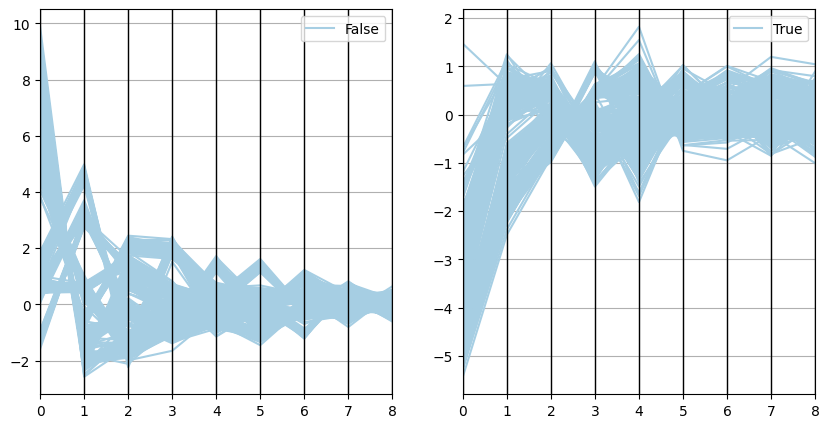

In [ ]:
plt.figure(figsize=[10,5])
plt.subplot(121)
pd.plotting.parallel_coordinates(df_x2[df_x2['target'] == 0],'target', colormap=plt.get_cmap("Paired"))
plt.subplot(122)
pd.plotting.parallel_coordinates(df_x2[df_x2['target'] == 1],'target', colormap=plt.get_cmap("Paired"))
plt.show()

Ao comparar os gráficos resultantes de X1 e X2 fica nítido que pelo fato do X1 possuir uma grande quantidade de colunas, se torna difícil a visualização, com muitos dados sobrepostos e sendo inviável notar alguma diferença entre a estrutura danificada e a não danificada. Porém, ao plotar os gráficos de X2, nota-se uma grande diferença de visualização dos dados, uma vez que estão mais limpos e distribuídos, sendo possível identificar diferenças gráficas entre as estruturas, e com o x2_scaled o range de análise é reduzindo, melhorando o custo computacional e o sucesso na resolução do problema.

##Dividindo em dados de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X2_scaled, y_target, test_size=0.33, random_state=42)

In [ ]:
X_train.shape

(569, 9)

##Aplicação do modelo softmax

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)
model.fit(X_train,y_train)

yhat = model.predict(X_test)

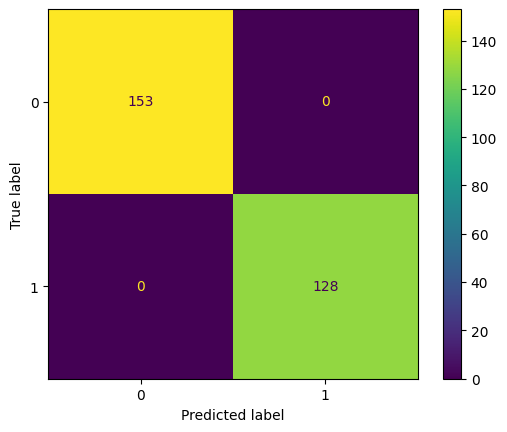

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

cm = confusion_matrix(y_test, yhat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Foram feitos alguns testes com outros valores de iteração, mas o resultado se manteve o mesmo.

In [ ]:
model2 = LogisticRegression(solver="lbfgs",C=10)
model2.fit(X_train,y_train)

yhat = model2.predict(X_test)

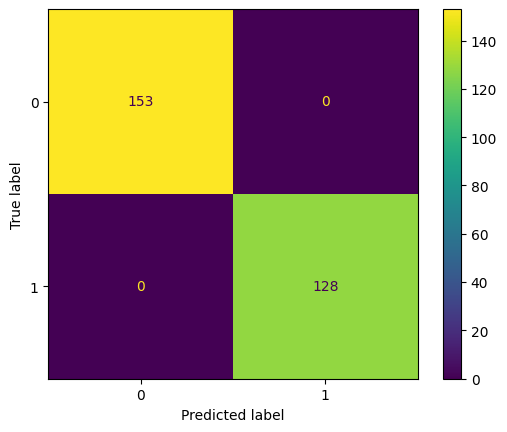

In [ ]:
cm2 = confusion_matrix(y_test, yhat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()

Mesmo com a alteração dos hiperparâmetros, a matriz confusão se manteve intacta, o que demonstra um bom modelo, mas também se trata de um problema relativamente simples.

#Aula 3

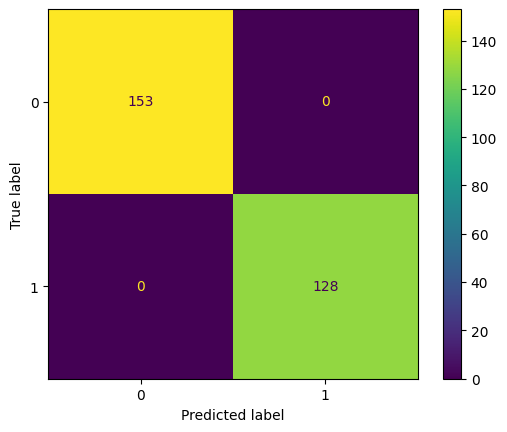

In [ ]:
from sklearn.svm import SVC

model_svc = SVC(kernel = 'poly')
model_svc.fit(X_train,y_train)

yhat_svc = model_svc.predict(X_test)

cm= confusion_matrix(y_test, yhat_svc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


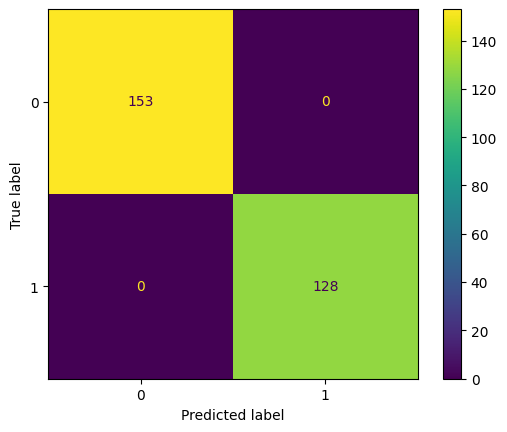

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=50)
model_knn.fit(X_train,y_train)

yhat_knn = model_knn.predict(X_test)

cm= confusion_matrix(y_test, yhat_knn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

##Testando hiperparâmetros diferentes

###SVC

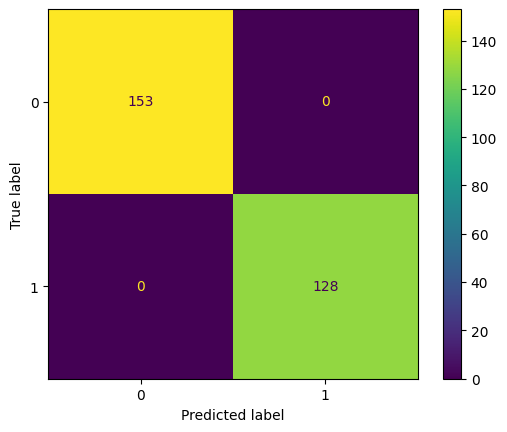

In [ ]:
model_svc2 = SVC(kernel = 'rbf')
model_svc2.fit(X_train,y_train)

yhat_svc2 = model_svc2.predict(X_test)

cm2= confusion_matrix(y_test, yhat_svc2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()

In [ ]:
accuracy = accuracy_score(y_test, yhat_svc2)
print(f"Acurácia: {accuracy:.4f}")

balanced_accuracy = balanced_accuracy_score(y_test, yhat_svc2)
print(f"Acurácia Balanceada: {balanced_accuracy:.4f}")

Acurácia: 1.0000
Acurácia Balanceada: 1.0000


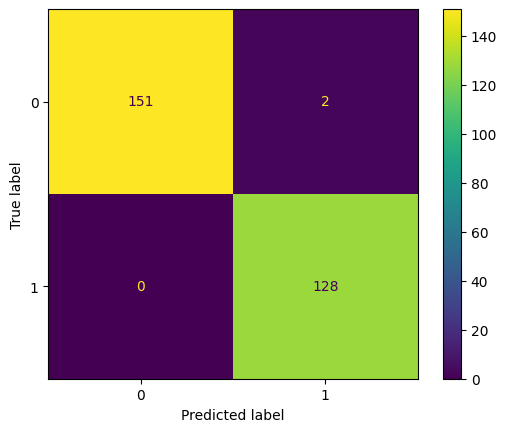

In [ ]:
model_svc3 = SVC(kernel='sigmoid', C=10)
model_svc3.fit(X_train,y_train)

yhat_svc3 = model_svc3.predict(X_test)

cm3= confusion_matrix(y_test, yhat_svc3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp.plot()

In [ ]:
accuracy = accuracy_score(y_test, yhat_svc3)
print(f"Acurácia: {accuracy:.4f}")

balanced_accuracy = balanced_accuracy_score(y_test, yhat_svc3)
print(f"Acurácia Balanceada: {balanced_accuracy:.4f}")

Acurácia: 0.9929
Acurácia Balanceada: 0.9935


###KNN

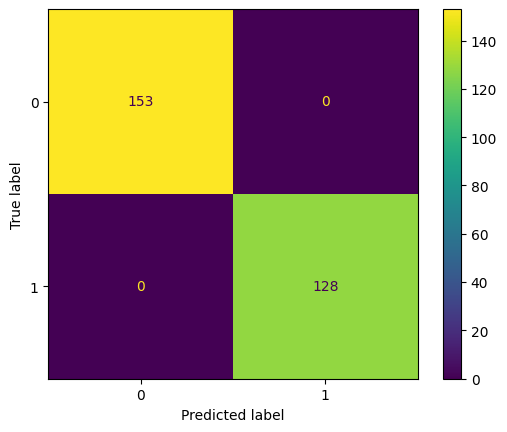

In [ ]:
model_knn2 = KNeighborsClassifier(n_neighbors=30, metric='manhattan')
model_knn2.fit(X_train, y_train)

yhat_knn2 = model_knn2.predict(X_test)

cm2 = confusion_matrix(y_test, yhat_knn2)

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot()

In [ ]:
accuracy = accuracy_score(y_test, yhat_knn2)
print(f"Acurácia: {accuracy:.4f}")

balanced_accuracy = balanced_accuracy_score(y_test, yhat_knn2)
print(f"Acurácia Balanceada: {balanced_accuracy:.4f}")

Acurácia: 1.0000
Acurácia Balanceada: 1.0000


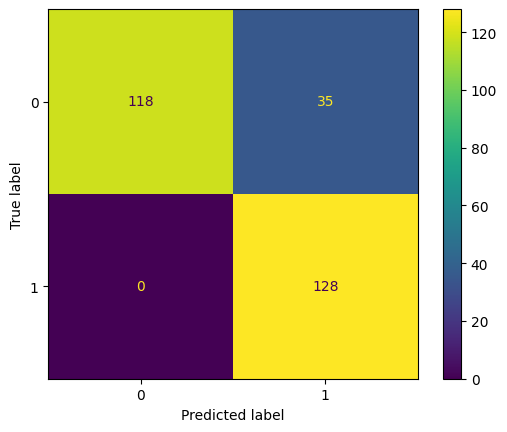

In [ ]:
model_knn3 = KNeighborsClassifier(n_neighbors=100, metric='euclidean')
model_knn3.fit(X_train,y_train)

yhat_knn3 = model_knn3.predict(X_test)

cm3= confusion_matrix(y_test, yhat_knn3)

disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp3.plot()

In [ ]:
accuracy = accuracy_score(y_test, yhat_knn3)
print(f"Acurácia: {accuracy:.4f}")

balanced_accuracy = balanced_accuracy_score(y_test, yhat_knn3)
print(f"Acurácia Balanceada: {balanced_accuracy:.4f}")

Acurácia: 0.8754
Acurácia Balanceada: 0.8856


##Conclusão

No modelo SVM os dados da matriz confusão permaneceram basicamente os mesmos, sendo possível notar um pequeno erro quando aplicado o kernel='sigmoid'e C=10 como hiperparâmetro, porém o erro foi muito pequeno, justamente por se tratar de um problema fácil, chegando a uma acurácia mínima (entre os testados) de 99%.

Já na aplicação do KNN, foi possível encontrar um pequeno erro quando aplicado um número maior de vizinhos, a partir de 65 o modelo já começa a encontrar alguns erros de predição, chegando a uma acurácia mínima (entre os testados) de 87%.